In [ ]:
!pip install imbalanced-learn
!pip install nltk

In [ ]:
import nltk
nltk.download('punkt')
# nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens if word not in stop_words]
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import re
import pandas as pd
import nltk
nltk.download('wordnet')
import nltk
nltk.download('punkt_tab')

df = pd.read_excel("/content/MedInfo2019-QA-MedicationsFINAL (1).xlsx")
df = df.dropna(subset=["Question", "Risk_Level"])
df_final= df.copy()
df_final["Question"] = df_final["Question"].apply(clean_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(df_final["Question"])

print(f"Original dimensionality (number of features): {X_tfidf.shape[1]}")
print(f"Number of training samples: {X_tfidf.shape[0]}")

Original dimensionality (number of features): 1052
Number of training samples: 655


In [ ]:
if X_tfidf.shape[1] > X_tfidf.shape[0]:
    print("The number of features exceeds the number of training samples. Dimensionality reduction is recommended.")
else:
    print("The number of features is reasonable given the number of training samples.")

The number of features exceeds the number of training samples. Dimensionality reduction is recommended.


In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=200, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

print(f"Reduced dimensionality (number of features): {X_reduced.shape[1]}")

Reduced dimensionality (number of features): 200


Shape after adding critical similarity: (655, 201)


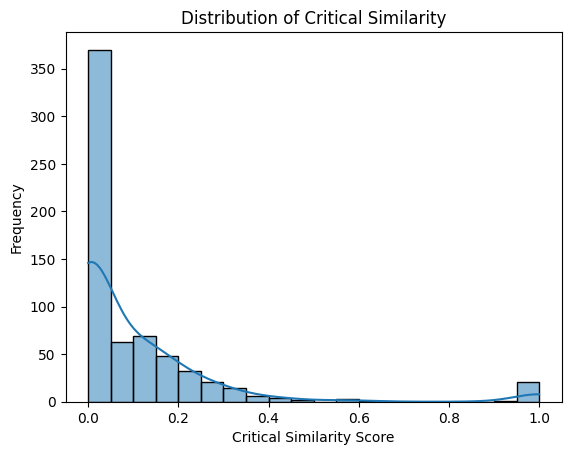

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Retrieving questions marked as Critical
critical_phrases = df_final[df_final["Risk_Level"] == "Critical"]["Question"].tolist()
critical_phrases = [q for q in critical_phrases if len(q.split()) > 3]
critical_phrases = critical_phrases[:20]

# TF-IDF + Cosine Similarity Calculation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer_critical = TfidfVectorizer(stop_words='english')
tfidf_matrix_critical = vectorizer_critical.fit_transform(df_final["Question"].tolist() + critical_phrases)

question_vectors = tfidf_matrix_critical[:len(df_final)]
critical_vectors = tfidf_matrix_critical[len(df_final):]

cosine_similarities = cosine_similarity(question_vectors, critical_vectors)

df_final["critical_similarity"] = np.max(cosine_similarities, axis=1)

# Integrating the feature with X_reduced
X_full = np.hstack((X_reduced, df_final["critical_similarity"].values.reshape(-1, 1)))

print(f"Shape after adding critical similarity: {X_full.shape}")

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_final["critical_similarity"], bins=20, kde=True)
plt.title("Distribution of Critical Similarity")
plt.xlabel("Critical Similarity Score")
plt.ylabel("Frequency")
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_final['Risk_Level'])

X = X_full

from sklearn.model_selection import train_test_split

# Divided into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


models = {
    "Logistic Regression": Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', LogisticRegression(max_iter=1000, penalty='l2', C=0.3, solver='liblinear', class_weight='balanced'))
    ]),
    "Random Forest": Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', RandomForestClassifier(n_estimators=100, max_depth=1, min_samples_split=10, min_samples_leaf=5, random_state=42))
    ]),
    "SVM": Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', SVC(kernel='linear',C=0.1, max_iter=2000))
    ]),
    "Gradient Boosting": Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', GradientBoostingClassifier(n_estimators=20, learning_rate=0.02, max_depth=2, min_samples_leaf=8, random_state=42))
    ]),
    "KNN": Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', KNeighborsClassifier(n_neighbors=20, weights='uniform'))
        ]),
    "SGD Logistic (L2)": Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', SGDClassifier(loss='log_loss', penalty='l2', alpha=0.005, max_iter=1000, random_state=42))
    ])
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}

for name, pipeline in models.items():
    print(f"\nEvaluating {name} with SMOTE + Cross-Validation (Train/Test)...")
    scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, return_train_score=True)

    train_f1 = np.mean(scores['train_f1'])
    test_f1 = np.mean(scores['test_f1'])
    gap = train_f1 - test_f1

    cv_results[name] = {
        'train_accuracy': np.mean(scores['train_accuracy']),
        'train_f1': train_f1,
        'test_accuracy': np.mean(scores['test_accuracy']),
        'test_precision': np.mean(scores['test_precision']),
        'test_recall': np.mean(scores['test_recall']),
        'test_f1': test_f1,
        'f1_gap': gap
    }

    print(f"Train Accuracy:  {cv_results[name]['train_accuracy']:.4f}")
    print(f"Train F1 Score:  {cv_results[name]['train_f1']:.4f}")
    print(f"Test Accuracy:   {cv_results[name]['test_accuracy']:.4f}")
    print(f"Test F1 Score:   {cv_results[name]['test_f1']:.4f}")
    print(f"Gap (Train - Test F1): {gap:.4f}")

    if gap > 0.10:
        print("🔴 Overfitting suspected\n")
    else:
        print("🟢 Generalizes well\n")

final_model = models["Logistic Regression"]
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print("Final test set F1 Score (20% held-out):", f1_score(y_test, y_pred, average='weighted'))

from sklearn.metrics import classification_report

print("\n🔍 Classification Report on Final 20% Test Set:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Evaluating Logistic Regression with SMOTE + Cross-Validation (Train/Test)...
Train Accuracy:  0.8402
Train F1 Score:  0.8471
Test Accuracy:   0.7615
Test F1 Score:   0.7700
Gap (Train - Test F1): 0.0772
🟢 Generalizes well


Evaluating Random Forest with SMOTE + Cross-Validation (Train/Test)...
Train Accuracy:  0.7653
Train F1 Score:  0.7851
Test Accuracy:   0.6811
Test F1 Score:   0.7040
Gap (Train - Test F1): 0.0811
🟢 Generalizes well


Evaluating SVM with SMOTE + Cross-Validation (Train/Test)...
Train Accuracy:  0.8626
Train F1 Score:  0.8353
Test Accuracy:   0.8435
Test F1 Score:   0.8028
Gap (Train - Test F1): 0.0325
🟢 Generalizes well


Evaluating Gradient Boosting with SMOTE + Cross-Validation (Train/Test)...
Train Accuracy:  0.8163
Train F1 Score:  0.8048
Test Accuracy:   0.7862
Test F1 Score:   0.7716
Gap (Train - Test F1): 0.0332
🟢 Generalizes well


Evaluating KNN with SMOTE + Cross-Validation (Train/Test)...
Train Accuracy:  0.2190
Train F1 Score:  0.1419
Test Accuracy:   0

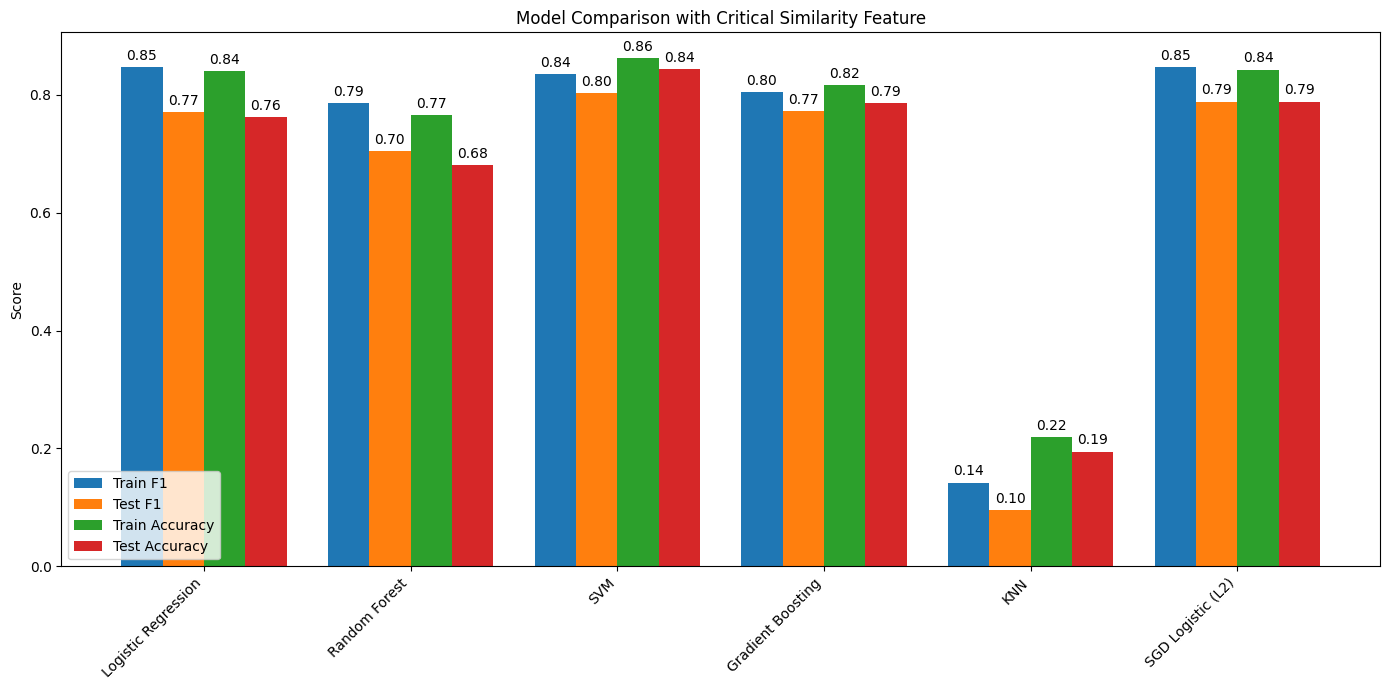

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Results of all models after adding critical_similarity
model_names = list(cv_results.keys())
train_f1 = [cv_results[m]["train_f1"] for m in model_names]
test_f1 = [cv_results[m]["test_f1"] for m in model_names]
train_acc = [cv_results[m]["train_accuracy"] for m in model_names]
test_acc = [cv_results[m]["test_accuracy"] for m in model_names]

x = np.arange(len(model_names))
width = 0.2

fig, ax = plt.subplots(figsize=(14, 7))

rects1 = ax.bar(x - 1.5*width, train_f1, width, label='Train F1')
rects2 = ax.bar(x - 0.5*width, test_f1, width, label='Test F1')
rects3 = ax.bar(x + 0.5*width, train_acc, width, label='Train Accuracy')
rects4 = ax.bar(x + 1.5*width, test_acc, width, label='Test Accuracy')


ax.set_ylabel('Score')
ax.set_title('Model Comparison with Critical Similarity Feature')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend()

for rect in rects1 + rects2 + rects3 + rects4:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Label Coding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_final['Risk_Level'])

X = X_reduced

# Divided into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


models = {
    "Logistic Regression": Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', LogisticRegression(max_iter=1000, penalty='l2', C=0.3, solver='liblinear', class_weight='balanced'))
    ]),
    "Random Forest": Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', RandomForestClassifier(n_estimators=100, max_depth=1, min_samples_split=10, min_samples_leaf=5, random_state=42))
    ]),
    "SVM": Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', SVC(kernel='linear',C=0.1, max_iter=2000))
    ]),
    "Gradient Boosting": Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', GradientBoostingClassifier(n_estimators=20, learning_rate=0.02, max_depth=2, min_samples_leaf=8, random_state=42))
    ]),
    "KNN": Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', KNeighborsClassifier(n_neighbors=20, weights='uniform'))
        ]),
    "SGD Logistic (L2)": Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', SGDClassifier(loss='log_loss', penalty='l2', alpha=0.005, max_iter=1000, random_state=42))
    ])
}


scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

#crossvalidation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results2 = {}

for name, pipeline in models.items():
    print(f"\nEvaluating {name} with SMOTE + Cross-Validation (Train/Test)...")
    scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, return_train_score=True)

    train_f1 = np.mean(scores['train_f1'])
    test_f1 = np.mean(scores['test_f1'])
    gap = train_f1 - test_f1

    cv_results2[name] = {
        'train_accuracy': np.mean(scores['train_accuracy']),
        'train_f1': train_f1,
        'test_accuracy': np.mean(scores['test_accuracy']),
        'test_precision': np.mean(scores['test_precision']),
        'test_recall': np.mean(scores['test_recall']),
        'test_f1': test_f1,
        'f1_gap': gap
    }

    print(f"Train Accuracy:  {cv_results2[name]['train_accuracy']:.4f}")
    print(f"Train F1 Score:  {cv_results2[name]['train_f1']:.4f}")
    print(f"Test Accuracy:   {cv_results2[name]['test_accuracy']:.4f}")
    print(f"Test F1 Score:   {cv_results2[name]['test_f1']:.4f}")
    print(f"Gap (Train - Test F1): {gap:.4f}")

    if gap > 0.10:
        print("🔴 Overfitting suspected\n")
    else:
        print("🟢 Generalizes well\n")

final_model = models["Logistic Regression"]
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print("Final test set F1 Score (20% held-out):", f1_score(y_test, y_pred, average='weighted'))

from sklearn.metrics import classification_report

print("\n🔍 Classification Report on Final 20% Test Set:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Evaluating Logistic Regression with SMOTE + Cross-Validation (Train/Test)...
Train Accuracy:  0.8707
Train F1 Score:  0.8763
Test Accuracy:   0.7329
Test F1 Score:   0.7395
Gap (Train - Test F1): 0.1368
🔴 Overfitting suspected


Evaluating Random Forest with SMOTE + Cross-Validation (Train/Test)...
Train Accuracy:  0.7676
Train F1 Score:  0.7739
Test Accuracy:   0.6925
Test F1 Score:   0.7012
Gap (Train - Test F1): 0.0727
🟢 Generalizes well


Evaluating SVM with SMOTE + Cross-Validation (Train/Test)...
Train Accuracy:  0.8111
Train F1 Score:  0.8272
Test Accuracy:   0.6775
Test F1 Score:   0.7012
Gap (Train - Test F1): 0.1260
🔴 Overfitting suspected


Evaluating Gradient Boosting with SMOTE + Cross-Validation (Train/Test)...
Train Accuracy:  0.7934
Train F1 Score:  0.7888
Test Accuracy:   0.7194
Test F1 Score:   0.7140
Gap (Train - Test F1): 0.0748
🟢 Generalizes well


Evaluating KNN with SMOTE + Cross-Validation (Train/Test)...
Train Accuracy:  0.2185
Train F1 Score:  0.1412
Test Acc

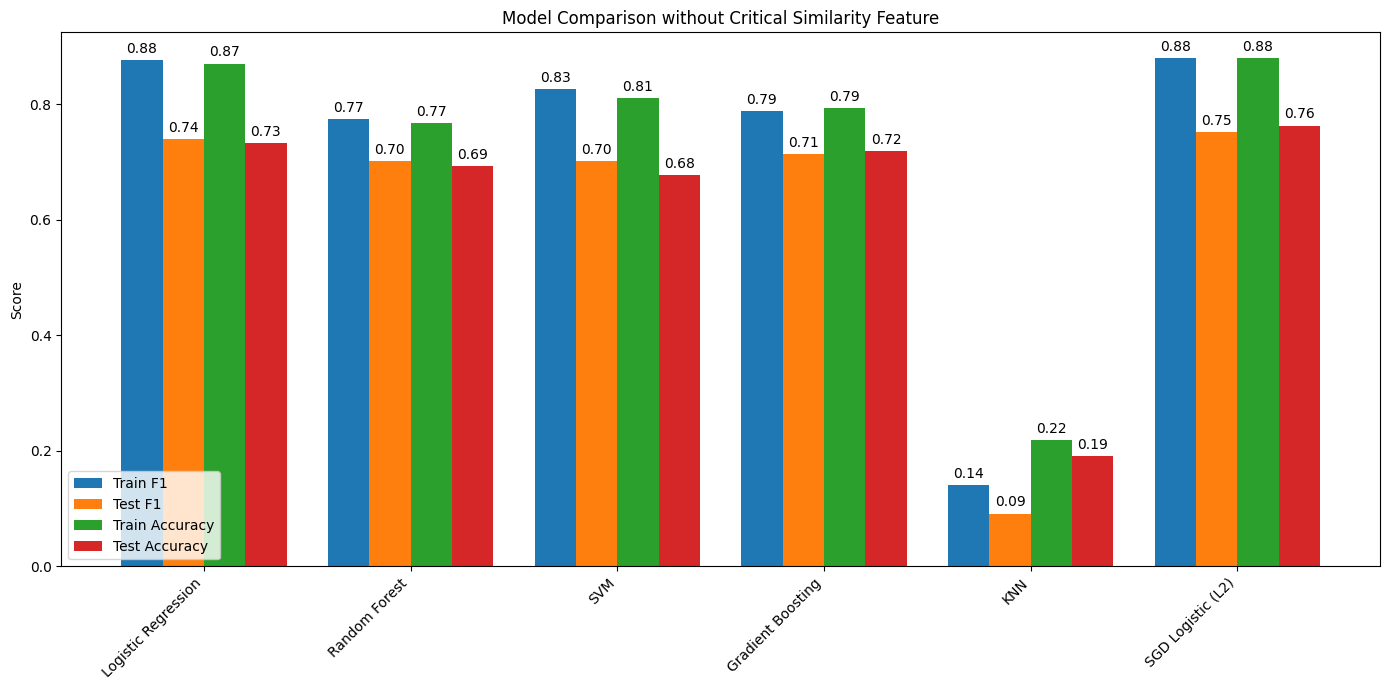

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Results of all models after adding critical_similarity
model_names = list(cv_results.keys())
train_f1 = [cv_results2[m]["train_f1"] for m in model_names]
test_f1 = [cv_results2[m]["test_f1"] for m in model_names]
train_acc = [cv_results2[m]["train_accuracy"] for m in model_names]
test_acc = [cv_results2[m]["test_accuracy"] for m in model_names]

x = np.arange(len(model_names))
width = 0.2

fig, ax = plt.subplots(figsize=(14, 7))

rects1 = ax.bar(x - 1.5*width, train_f1, width, label='Train F1')
rects2 = ax.bar(x - 0.5*width, test_f1, width, label='Test F1')
rects3 = ax.bar(x + 0.5*width, train_acc, width, label='Train Accuracy')
rects4 = ax.bar(x + 1.5*width, test_acc, width, label='Test Accuracy')

ax.set_ylabel('Score')
ax.set_title('Model Comparison without Critical Similarity Feature')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend()

for rect in rects1 + rects2 + rects3 + rects4:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
# Results of Everything Models After Critical Aging_Similarity
pipeline_basic = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000))
])

scores_basic = cross_validate(pipeline_basic, X_reduced, y, scoring=scoring, cv=cv, return_train_score=True)
print(f"Without Critical Similarity - Test F1: {np.mean(scores_basic['test_f1']):.4f}")

#Step 2: Train a model on X_full
pipeline_critical = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000))
])

scores_critical = cross_validate(pipeline_critical, X_full, y, scoring=scoring, cv=cv, return_train_score=True)
print(f"With Critical Similarity - Test F1: {np.mean(scores_critical['test_f1']):.4f}")


Without Critical Similarity - Test F1: 0.7656
With Critical Similarity - Test F1: 0.7822


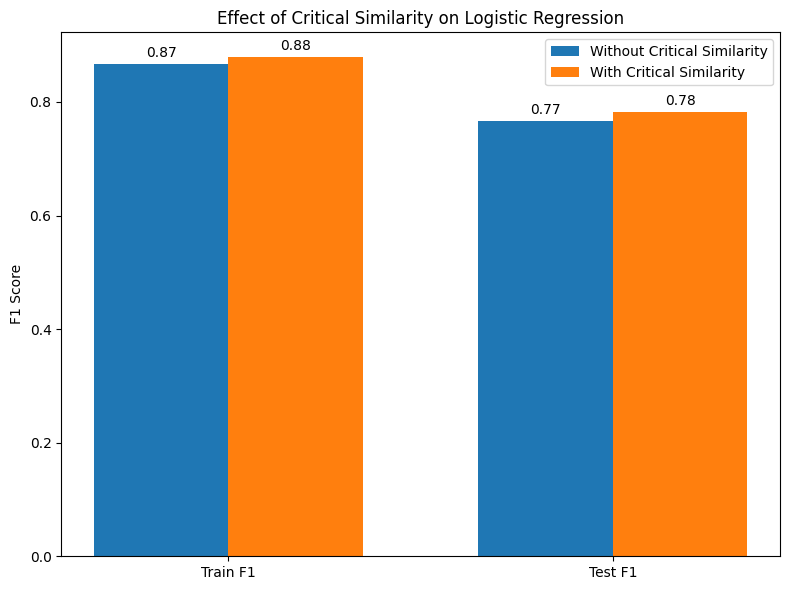

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

#Step 1: Train a model on X_reduced
pipeline_basic = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000))
])
scores_basic = cross_validate(pipeline_basic, X_reduced, y, scoring=scoring, cv=cv, return_train_score=True)

# Step 2: Model Training on X_full (including Critical Similarity)
pipeline_critical = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000))
])
scores_critical = cross_validate(pipeline_critical, X_full, y, scoring=scoring, cv=cv, return_train_score=True)

# Calculate Averages
basic_train_f1 = np.mean(scores_basic['train_f1'])
basic_test_f1 = np.mean(scores_basic['test_f1'])
critical_train_f1 = np.mean(scores_critical['train_f1'])
critical_test_f1 = np.mean(scores_critical['test_f1'])

# Comparative Graph
labels = ['Train F1', 'Test F1']
basic_scores = [basic_train_f1, basic_test_f1]
critical_scores = [critical_train_f1, critical_test_f1]

x = np.arange(len(labels))  # 0,1
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, basic_scores, width, label='Without Critical Similarity')
rects2 = ax.bar(x + width/2, critical_scores, width, label='With Critical Similarity')

ax.set_ylabel('F1 Score')
ax.set_title('Effect of Critical Similarity on Logistic Regression')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


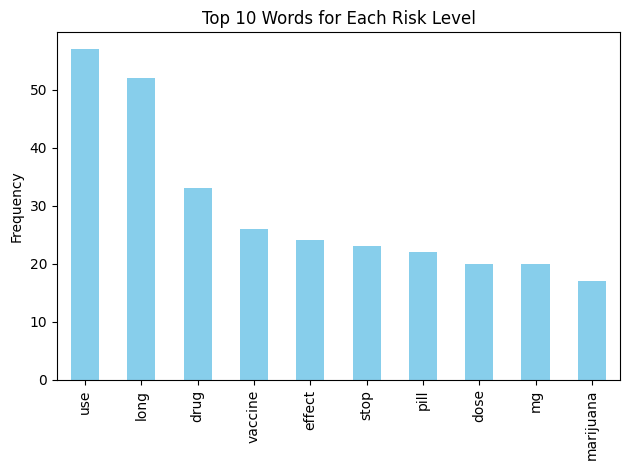

In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
# Creating vectorization by categories
category_words = df_final.groupby('Risk_Level')['Question'].apply(lambda x: ' '.join(x))
# Calculating word frequency for each category
category_vectorizer = CountVectorizer(stop_words='english')
category_X = category_vectorizer.fit_transform(category_words)
# Frequency calculation
category_word_freq = pd.DataFrame(category_X.toarray(), columns=category_vectorizer.get_feature_names_out(), index=category_words.index)
category_word_freq = category_word_freq.sum(axis=0).sort_values(ascending=False)
# Show the most common words for each category
category_word_freq.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Words for Each Risk Level')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()